## 2022 NBA Champion Prediction

In [1]:
import configparser
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base
import xgboost

### Read in Our Data
##### Read config.ini File

In [2]:
config = configparser.ConfigParser()
config.read(Path("config.ini"))

['config.ini']

##### Configure Credentials

In [3]:
# database and root user credentials
host = config["DATABASE"]["HOST"]
port = config["DATABASE"]["PORT"]
db = config["DATABASE"]["DB"]

# root user credentials
root_user = config["ROOT"]["USERNAME"]
root_pwd = config["ROOT"]["USERNAME"]

# root user db uri
root_db_uri = f"postgresql://{root_user}:{root_pwd}@{host}:{port}/{db}"


# user credentials
user = config["USER"]["USERNAME"]
pwd = config["USER"]["PASSWORD"]

# user db uri
user_db_uri = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"

##### Setup SQLAlchemy Engine and Reflect Our Database

In [4]:
engine = create_engine(root_db_uri)

# Create an automap base class
Base = automap_base()
# reflect the tables (this creates the mapping between for our tables)
Base.prepare(engine=engine, autoload_with=engine)
Base.classes.keys()

['teams_traditional',
 'teams_advanced',
 'teams_misc',
 'teams_clutch',
 'playoffs_traditional',
 'playoffs_advanced',
 'playoffs_misc',
 'playoffs_clutch',
 'playoff_teams_long',
 'champions']

In [5]:
# Save references to each table from the mapping
TeamsTraditional = Base.classes.teams_traditional
TeamsAdvanced = Base.classes.teams_advanced
TeamsMisc = Base.classes.teams_misc
TeamsClutch = Base.classes.teams_clutch

##### Query Our Database and Convert to DataFrames

In [6]:
# Create the session
Session = sessionmaker(engine)  

# Create 2 variables, one with references to our tables, and the other an empty
# dictionary to collect the resulting DataFrames
tables = {
    "traditional": TeamsTraditional,
    "advanced": TeamsAdvanced,
    "misc": TeamsMisc,
    "clutch": TeamsClutch,
}

# Dictionaries to hold the dataframes. There are two because we will need to separate the data of
# the current season (2022) from all the past seasons (past seasons will serve as our train/test data).
dataframes = {}
dataframes_22 = {}

# Loop through each table reference, query the data from our DB, and convert to
# a DataFrame
season_current = 2022
season_start = 2016

with Session() as session:
    for stat_type, table in tables.items():
        # Query the table
        query = session.query(table)
        # Use the query's SQL statement to read into a DataFrame
        df = pd.read_sql(sql=query.statement, con=engine)
        # Change season column to the year as an integer
        df["SEASON"] = df["SEASON"].dt.year
        # Filter out the non-playoff teams and drop the PLAYOFFS columns as well as team record info 
        df = df[df["PLAYOFFS"] == True].drop(columns=["GP", "W", "L", "PLAYOFFS"])
        
        # Slice the DataFrame to separate the 2022 season (that doesn't have a champion) from all of
        # the past seasons
        df_22 = df[df["SEASON"] == season_current]
        df = df[(df["SEASON"] >= season_start) & (df["SEASON"] < season_current)]

        # Create a new team identifier by combining the year and team name
        df_22["TEAM"] = df_22["SEASON"].astype(dtype="str") + " " + df_22["TEAM"]
        df["TEAM"] = df["SEASON"].astype(dtype="str") + " " + df["TEAM"]

        # Drop the season column
        df_22 = df_22.drop(columns="SEASON")
        df = df.drop(columns="SEASON")

        # Reset the index and assign the transformed DataFrame to the "output" dictionaries
        dataframes_22[stat_type] = df_22.reset_index(drop=True)
        dataframes[stat_type] = df.reset_index(drop=True)

# Assign the DataFrames to variables with same names as our tables from our DB
teams_traditional = dataframes["traditional"]
teams_advanced = dataframes["advanced"]
teams_misc = dataframes["misc"]
teams_clutch = dataframes["clutch"]

# Assign the 2022 DataFrames to variables with same names as our tables from our DB with suffix for 2022
teams_traditional_22 = dataframes_22["traditional"]
teams_advanced_22 = dataframes_22["advanced"]
teams_misc_22 = dataframes_22["misc"]
teams_clutch_22 = dataframes_22["clutch"]

##### Check Number of Records for Each DataFrame

In [7]:
teams_traditional.columns

Index(['TEAM', 'WIN%', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'BLKA', 'PF', 'PFD', '+/-', 'CHAMPION'],
      dtype='object')

In [8]:
print("traditional count = ", len(teams_traditional))
print("advanced count = ", len(teams_advanced))
print("misc count = ", len(teams_misc))
print("clutch count = ", len(teams_clutch))

print("2022 traditional count = ", len(teams_traditional_22))
print("2022 advanced count = ", len(teams_advanced_22))
print("2022 misc count = ", len(teams_misc_22))
print("2022 clutch count = ", len(teams_clutch_22))

traditional count =  96
advanced count =  96
misc count =  96
clutch count =  96
2022 traditional count =  16
2022 advanced count =  16
2022 misc count =  16
2022 clutch count =  16


##### Merge All Stats Into One Table for Past and Current Seasons Each
Select Features

In [9]:
features = [
    # 'WIN%',
    # 'PTS',
    # 'FGM',
    # 'FGA',
    # 'FG%',
    # '3PM',
    # '3PA',
    '3P%',
    # 'FTM',
    # 'FTA',
    # 'FT%',
    # 'OREB',
    'DREB',
    # 'REB',
    # 'AST',
    # 'TOV',
    'STL',
    'BLK',
    # 'BLKA',
    # 'PF',
    # 'PFD',
    # '+/-',
    'OFFRTG',
    'DEFRTG',
    # 'NETRTG',
    # 'AST%',
    'AST/TO',
    # 'AST RATIO',
    # 'OREB%',
    # 'DREB%',
    # 'REB%',
    # 'TOV%',
    # 'EFG%',
    # 'TS%',
    # 'PACE',
    # 'PIE',
    # 'POSS',
    # 'PTS OFF TO',
    # '2ND PTS',
    # 'FBPS',
    # 'PITP',
    # 'OPP PTS OFF TO',
    # 'OPP 2ND PTS',
    # 'OPP FBPS',
    # 'OPP PITP'
]

In [10]:
features_all = [
    'WIN%',
    'PTS',
    'FGM',
    'FGA',
    'FG%',
    '3PM',
    '3PA',
    '3P%',
    'FTM',
    'FTA',
    'FT%',
    'OREB',
    'DREB',
    'REB',
    'AST',
    'TOV',
    'STL',
    'BLK',
    'BLKA',
    'PF',
    'PFD',
    '+/-',
    'OFFRTG',
    'DEFRTG',
    'NETRTG',
    'AST%',
    'AST/TO',
    'AST RATIO',
    'OREB%',
    'DREB%',
    'REB%',
    'TOV%',
    'EFG%',
    'TS%',
    'PACE',
    'PIE',
    'POSS',
    'PTS OFF TO',
    '2ND PTS',
    'FBPS',
    'PITP',
    'OPP PTS OFF TO',
    'OPP 2ND PTS',
    'OPP FBPS',
    'OPP PITP'
]

In [11]:
len(features)

7

Merge and Select Columns Based on Features Variable

In [12]:
# Merge traditional, advanced, and misc tables together
team_stats = (teams_traditional.merge(teams_advanced, on="TEAM", suffixes=["_t", "_a"])
                               .merge(teams_misc, on="TEAM", suffixes=["_t", "_a"]))

team_stats_22 = (teams_traditional_22.merge(teams_advanced_22, on="TEAM", suffixes=["_t", "_a"])
                                     .merge(teams_misc_22, on="TEAM", suffixes=["_t", "_a"]))

# Select the features columns into a new DataFrame
stats = team_stats[features]
stats_22 = team_stats_22[features]

# Assign the target labels
labels = team_stats["CHAMPION"]

#### Confusion Matrix (Correlation Between Stats)

Number of stats with max r-value < 0.8:  16 

Stats with max r-value < 0.8: ['AST/TO', 'FGA', 'REB%', 'DREB%', 'OPP 2ND PTS', '3P%', 'PITP', 'OPP PITP', 'DEFRTG', 'BLK', 'FBPS', 'BLKA', 'FT%', 'PF', 'OPP FBPS', 'POSS'] 



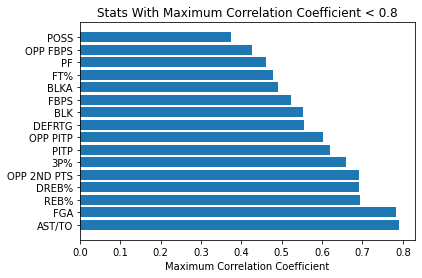

Number of stats with avg r-value < 0.35:  20 

Stats with avg r-value < 0.35: ['REB%', 'BLKA', 'TOV', 'OPP PTS OFF TO', 'AST%', 'FT%', 'FTA', 'OREB%', 'BLK', 'OPP 2ND PTS', 'TOV%', 'PF', 'DREB%', 'OPP FBPS', 'PFD', 'FTM', 'STL', '2ND PTS', 'PTS OFF TO', 'POSS'] 



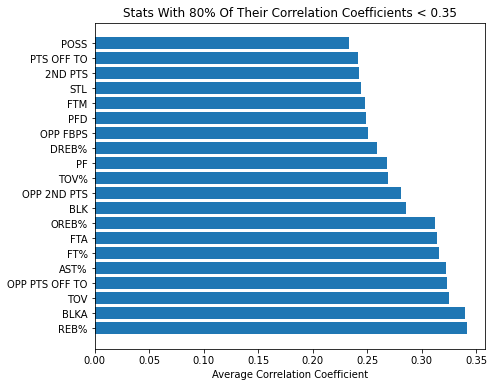

In [13]:
# Create a correlation matrix of the stats
corr = team_stats[features_all].corr()
corr = corr.round(4)

max_correlations = {}
avg_correlations = {}

quantile_val = 0.80
max_corr_cutoff = 0.8
avg_corr_cutoff = 0.35

for col_name, correlations in corr.items():
    abs_sorted_correlations = correlations.abs().sort_values(ascending=False)
    max_corr = abs_sorted_correlations.iloc[1]
    max_correlations[col_name] = max_corr
    avg_corr = abs_sorted_correlations.iloc[1:].quantile(q=quantile_val)
    avg_correlations[col_name] = avg_corr

# Max Correlation Data
max_correlations = pd.DataFrame(max_correlations.values(), index=pd.Index(max_correlations.keys()), columns=["Max Correlation"])
max_correlations = max_correlations.sort_values(by="Max Correlation", ascending=False)
max_correlations = max_correlations[max_correlations["Max Correlation"] < max_corr_cutoff]

print(f"Number of stats with max r-value < {max_corr_cutoff}: ", len(max_correlations), "\n")
print(f"Stats with max r-value < {max_corr_cutoff}:", list(max_correlations.index), "\n")

# Max Correlation Plot
plt.barh(max_correlations.index, max_correlations["Max Correlation"])
plt.title(f"Stats With Maximum Correlation Coefficient < {max_corr_cutoff}")
plt.xlabel("Maximum Correlation Coefficient")
plt.show()

# --------------------------------------------------------------------------------------
# Avg Correlation Data
avg_correlations = pd.DataFrame(avg_correlations.values(), index=pd.Index(avg_correlations.keys()), columns=["Avg Correlation"])
avg_correlations = avg_correlations.sort_values(by="Avg Correlation", ascending=False)
avg_correlations = avg_correlations[avg_correlations["Avg Correlation"] < avg_corr_cutoff]

print(f"Number of stats with avg r-value < {avg_corr_cutoff}: ", len(avg_correlations), "\n")
print(f"Stats with avg r-value < {avg_corr_cutoff}:", list(avg_correlations.index), "\n")

# Avg Correlation Plot
plt.figure(figsize=(7,6))
plt.barh(avg_correlations.index, avg_correlations["Avg Correlation"])
plt.title(f"Stats With {int(round(100*quantile_val))}% Of Their Correlation Coefficients < {avg_corr_cutoff}")
plt.xlabel("Average Correlation Coefficient")
plt.show()

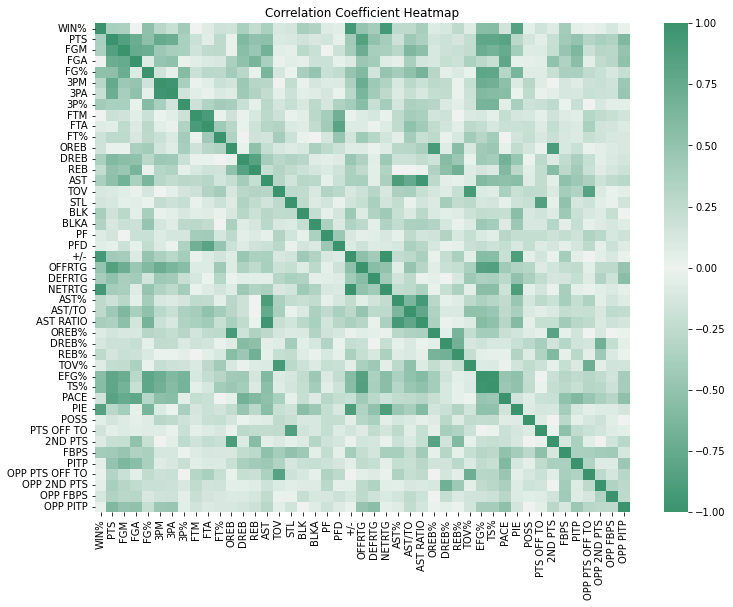

In [14]:
# Plot a heatmap of the correlations
f, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.color_palette("vlag", as_cmap=True)
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation Coefficient Heatmap")
plt.show()

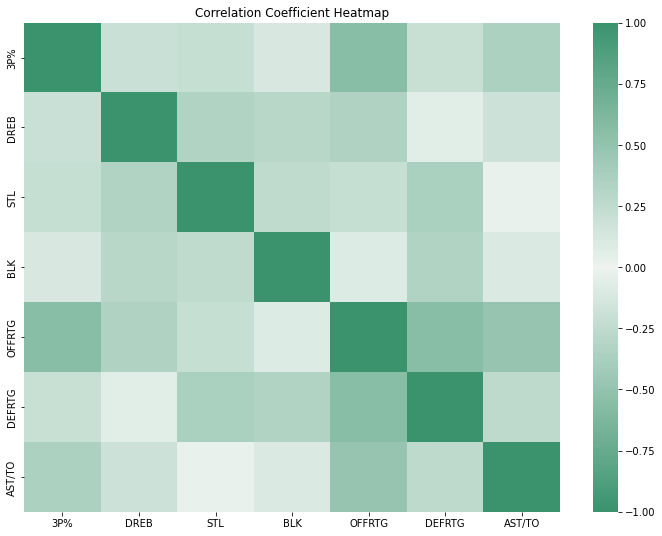

In [15]:
corr = stats.corr()
corr = corr.round(4)

# Plot a heatmap of the correlations
f, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
# cmap = sns.color_palette("vlag", as_cmap=True)
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1)
plt.title("Correlation Coefficient Heatmap")
plt.show()

In [16]:
team_stats.columns

Index(['TEAM', 'WIN%', 'MIN_t', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'CHAMPION_t', 'MIN_a', 'OFFRTG',
       'DEFRTG', 'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%',
       'REB%', 'TOV%', 'EFG%', 'TS%', 'PACE', 'PIE', 'POSS', 'CHAMPION_a',
       'MIN', 'PTS OFF TO', '2ND PTS', 'FBPS', 'PITP', 'OPP PTS OFF TO',
       'OPP 2ND PTS', 'OPP FBPS', 'OPP PITP', 'CHAMPION'],
      dtype='object')

### Machine Learning
#### Create a model with LogisticRegression().
1.  Create a model with LogisticRegression().
2.  Train the model with model.fit().
3. Make predictions with model.predict().
4. Validate the model with accuracy_score().

<br>
<hr>

#### Logistic Regression
##### Preprocess Our Data

One-Hot-Encode the Labels

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)
labels

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

Scale

In [18]:
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer
data_scaler = StandardScaler()
stats_transformed = data_scaler.fit_transform(stats)
stats_22_transformed = data_scaler.fit_transform(stats_22)
# pd.DataFrame(stats_transformed, columns=stats.columns)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.

PCA Dimensionality Reduction

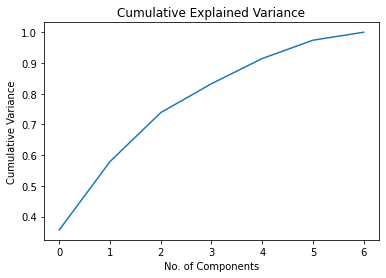

In [19]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='full').fit(stats_transformed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance")
plt.xlabel('No. of Components')
plt.ylabel('Cumulative Variance')
plt.show()
# pca = PCA(n_components=17, svd_solver='full')
# stats_transformed = pd.DataFrame(pca.fit_transform(stats))
# stats_transformed.shape

Assign to ML Input Variables

In [20]:
# Categorize features from the target
y = labels
# X = stats
X = stats_transformed
target = stats_22_transformed

##### Split our data into training and testing

In [21]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
# Stratifying the data is important since we have 25 champions and 375 non-champions (a strong
# imbalance across the two groups)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

##### Create a Logistic Regression Model

In [22]:
# Create a logistic regression model with the specified arguments
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="liblinear", max_iter=2000, random_state=1)

##### Fit (train) or model using the training data

In [23]:
# Train the model with the training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=1, solver='liblinear')

##### Test the Model Against X_test

In [24]:
# Create predictions for y-values
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test})

##### Validate the model using the test data

In [25]:
# Accuracy score
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9166666666666666


##### Confusion Matrix

(24,)
tn, fp, fn, tp:  [21  1  1  1]


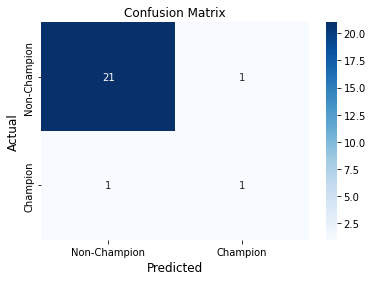

In [26]:
from sklearn.metrics import confusion_matrix
print(y_test.shape)
c_matrix = confusion_matrix(y_test, y_pred)
c = c_matrix
print("tn, fp, fn, tp: ", c.ravel())
sns.heatmap(c_matrix,
            xticklabels=["Non-Champion", "Champion"],
            yticklabels=["Non-Champion", "Champion"],
            annot=True,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

##### Make the Prediction

In [27]:
y_pred_22 = classifier.predict(stats_22_transformed)
champion_pred = pd.DataFrame({"Prediction": y_pred_22})

# Print out the predicted champion
predicted_champion = pd.DataFrame({"TEAM" : team_stats_22["TEAM"], "Prediction": champion_pred["Prediction"]})

pc = [team for team in predicted_champion[predicted_champion["Prediction"] == 1]["TEAM"]]
for champ in pc:
    print(f"Champion: {champ}")

Champion: 2022 Memphis Grizzlies


In [33]:
y_pred_22 = classifier.predict_proba(stats_22_transformed)
predicted_champion = pd.DataFrame({"TEAM" : team_stats_22["TEAM"], "Not-Champion": y_pred_22[:,0], "Champion": y_pred_22[:,1]})
predicted_champion.round(decimals=2)

,TEAM,Not-Champion,Champion
0,2022 Phoenix Suns,0.82,0.18
1,2022 Memphis Grizzlies,0.44,0.56
2,2022 Golden State Warriors,0.90,0.10
3,2022 Miami Heat,0.98,0.02
4,2022 Dallas Mavericks,0.99,0.01
5,2022 Boston Celtics,0.92,0.08
6,2022 Milwaukee Bucks,0.92,0.08
7,2022 Philadelphia 76ers,0.92,0.08
8,2022 Utah Jazz,0.91,0.09
9,2022 Denver Nuggets,0.97,0.03


In [29]:
f_importance = classifier.coef_[0]

In [30]:
feature_importance = 100*(f_importance/f_importance.max())

In [41]:
f = zip(stats.columns, feature_importance)
dict(f)

{'3P%': 15.504004759380324,
 'DREB': 23.403382922998333,
 'STL': 39.2035333691118,
 'BLK': 45.91080524152934,
 'OFFRTG': 50.121450121292035,
 'DEFRTG': 86.02294417667588,
 'AST/TO': 100.0}

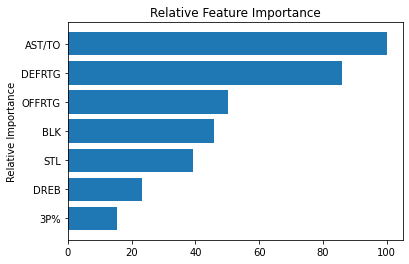

In [39]:

plt.barh(stats.columns,np.sort(feature_importance))
plt.title("Relative Feature Importance")
plt.ylabel("Relative Importance")
plt.show()

In [32]:
# plt.figure(figsize=(20,8))
pd.DataFrame(feature_importance, index=stats.columns, columns=["Relative Importance"]).sort_values(by="Relative Importance", ascending=False).round(3).head(20)#[:10].plot(kind='barh')
# plt.tight_layout()
# plt.show()

,Relative Importance
STL,100.000
BLK,86.023
OFFRTG,50.121
3P%,45.911
DREB,39.204
AST/TO,23.403
DEFRTG,15.504


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ec055ed-5f7e-442c-8e37-dd2a6068a4e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>